# IMU Calibration with Observability-Aware Partial Updates
This notebook recreates the observability-informed partial update procedure for an IMU + vision system, as proposed by Ramos et al. (2021). We use the `pykal` framework to define the dynamics, simulate measurements, and construct a Kalman filter that leverages state observability to regulate updates.

The system models inertial motion with bias drift, and observes position via visual measurements. The correction step uses a dynamic β(t) schedule derived from the local observability Gramian.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from pykal.system import System, SystemType
from pykal.ekf import EKF
from pykal.system import SystemIO


## Define System Dynamics and Measurement Functions

In [2]:
def f_imu_calibration(t: float, x: NDArray[np.float64]) -> NDArray[np.float64]:
    px, py, vx, vy, bax, bay = x.flatten()
    ax_meas = 0.0
    ay_meas = 0.0
    dt_bias = 1e-3
    return np.array([
        [vx],
        [vy],
        [ax_meas - bax],
        [ay_meas - bay],
        [dt_bias * np.random.randn()],
        [dt_bias * np.random.randn()],
    ])

def h_imu_visual(t: float, x: NDArray[np.float64]) -> NDArray[np.float64]:
    return x[0:2, :]

## Define Noise Models

In [3]:
def Q(t: float, x: NDArray[np.float64], u: NDArray[np.float64]) -> NDArray[np.float64]:
    return 1e-4 * np.eye(6)

def R(t: float, x: NDArray[np.float64], u: NDArray[np.float64]) -> NDArray[np.float64]:
    return 1e-2 * np.eye(2)

## Instantiate System

In [44]:
sys = System(
    f=f_imu_calibration,
    h=h_imu_visual,
    Q=Q,
    R=R,
    state_names=["px", "py", "vx", "vy", "bax", "bay"],
    measurement_names=["px", "py"],
    system_type=SystemType.CONTINUOUS_TIME_INVARIANT,
)

## Simulate Ground Truth and Measurements

In [61]:
x0 = np.zeros((6, 1))
T_span = (0, 10)
dt = 0.1
X, T = sys.simulate_states(x0=x0, dt=dt, t_span=T_span, process_noise=True)
Y, _ = sys.simulate_measurements(X=X_true, T=T, measurement_noise=False)

In [62]:
Y.shape

(2, 101)

In [63]:
Xdf = SystemIO.combine_data_and_time_into_DataFrame(X,T,sys.state_names)
Ydf = SystemIO.combine_data_and_time_into_DataFrame(Y,T,sys.measurement_names)

## Run EKF with Full Updates (Baseline)

In [64]:
ekf.sys.H(x0,x0,0)

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [65]:
ekf = EKF(sys)
X_full, P_full, _ = ekf.run(
    x0=x0,
    P0=1e-1 * np.eye(6),
    Y=Y.T,
    dt=dt,
    start_time=0.0,
    square_root=False,
    override_system_beta=None
)

## Derive Observability-Based β(t)

In [66]:
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from typing import Callable

def build_stochastic_observability_beta_from_series(
    P_series: pd.Series, T: NDArray
) -> Callable[[float], NDArray]:
    """
    Construct a time-varying β(t) function using marginal variances from
    a time-indexed series of covariance matrices.

    Parameters
    ----------
    P_series : pd.Series
        A Series of shape (T,), where each element is an (n, n) ndarray (covariance matrix).
    T : NDArray
        A 1D NumPy array of shape (T,) containing time stamps matching the index of `P_series`.

    Returns
    -------
    beta_fn : Callable[[float], NDArray]
        Time-varying β function of shape (n, 1), where each β_i ∈ [0, 1].
    """
    # Stack diagonals into shape (T, n)
    variances = np.array([np.diag(P) for P in P_series.to_numpy()])  # shape (T, n)
    variances = np.clip(variances, 1e-12, None)

    # Normalize each state over time
    normalized = variances / np.max(variances, axis=0)  # shape (T, n)
    beta_array = 1.0 - normalized  # shape (T, n)

    def beta_fn(t: float) -> NDArray:
        idx = np.searchsorted(T, t, side="right") - 1
        idx = np.clip(idx, 0, len(T) - 1)
        return beta_array[idx].reshape(-1, 1)  # shape (n, 1)

    return beta_fn



In [67]:
T = np.append(T, 10.1)

In [68]:
P_full.T.shape

(6, 6, 102)

In [69]:
P_full = SystemIO.combine_matrix_series_with_time(P_full.T, T)

In [70]:
beta_fn = build_stochastic_observability_beta_from_series(P_full, T)

## Rerun EKF with Observability-Informed Partial Updates

In [71]:
Xest, Pest, _ = ekf.run(
    x0=x0,
    P0=1e-1 * np.eye(6),
    Y=Y.T,
    dt=dt,
    start_time=0.0,
    square_root=False,
    override_system_beta=beta_fn
)

In [72]:
Xestdf = SystemIO.combine_data_and_time_into_DataFrame(Xest.T,T,sys.state_names)
Pestsr = SystemIO.combine_matrix_series_with_time(Pest.T,T)

/tmp/ipykernel_18411/1172645578.py:15: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(np.array([


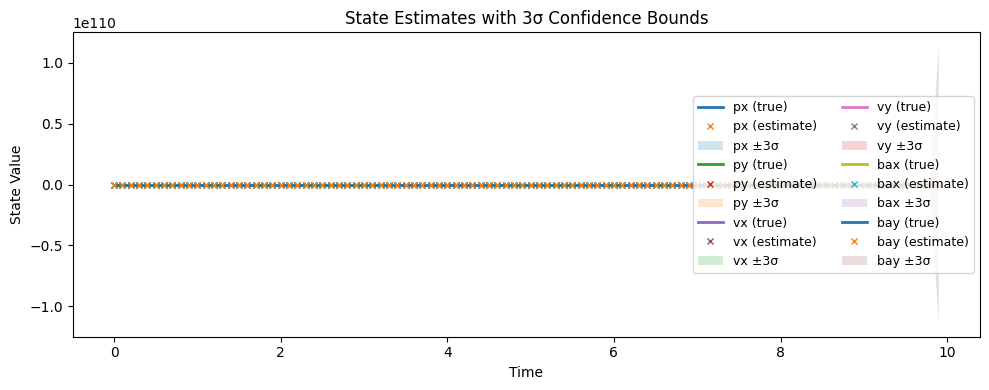

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Visualization: state estimates vs. ground truth with 3σ bounds
fig, ax = plt.subplots(figsize=(10, 4))

for col in Xdf.columns:
    idx = Xdf.columns.get_loc(col)  # Get index of current state variable

    # Align true states and estimated means
    true = Xdf[col].to_numpy()                 # shape (T,)
    mean = Xestdf[col].to_numpy()[:-2]         # shape (T-1,), skip final estimate

    # Extract per-timestep variances (assumes Pestsr[t] is (n, n))
    std = np.sqrt(np.array([
        Pestsr[t][idx, idx] for t in Xdf.index[:-1]  # assumes Xdf.index == T
    ]))  # shape (T-1,)

    # Plot true trajectory
    ax.plot(Xdf.index[:-1], true[:-1], label=f"{col} (true)", linewidth=2)

    # Plot estimated mean
    ax.plot(Xdf.index[:-1], mean, 'x', label=f"{col} (estimate)", markersize=5)

    # Plot 3-sigma confidence bounds
    ax.fill_between(
        Xdf.index[:-1], mean - 3 * std, mean + 3 * std,
        alpha=0.2, label=f"{col} ±3σ"
    )

ax.set_title("State Estimates with 3σ Confidence Bounds")
ax.set_xlabel("Time")
ax.set_ylabel("State Value")
ax.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


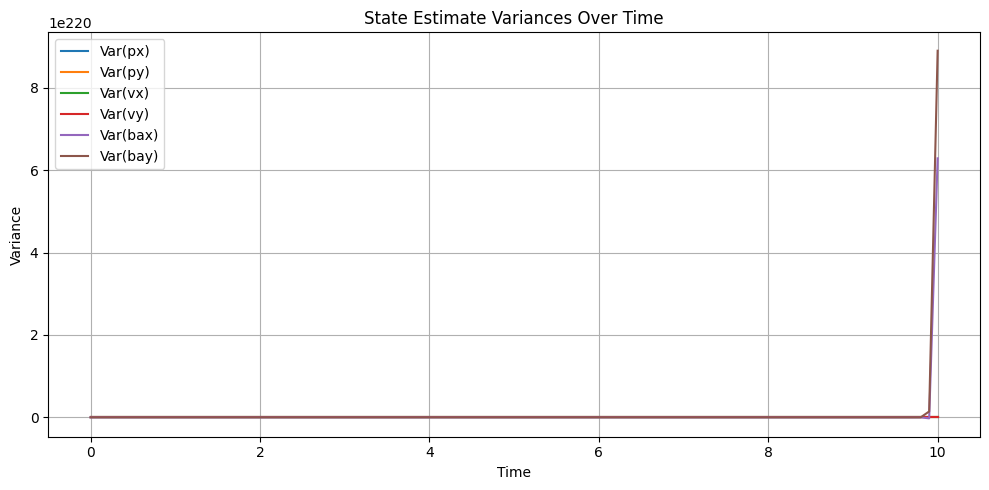

In [75]:
fig, ax = plt.subplots(figsize=(10, 5))

for idx, name in enumerate(sys.state_names):
    variances = np.array([Pestsr[t][idx, idx] for t in Xdf.index])
    ax.plot(Xdf.index, variances, label=f"Var({name})")

ax.set_title("State Estimate Variances Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Variance")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()